# Facial Emotion Recognition - VGG Face 2 Inception

### Introduction
The aim of this project is to predict the age, gender and emotion of a person from an image of their face using artificial neural networks trained on images from the FER-2013 facial recognition dataset.

We investigate the accuracy of age, gender and emotion prediction using use different neural network models. We evaluate each model using accuracy, F1 score, L1 mean absolute error, and training time.

This notebook predicts facial emotion using a VGG Face 2 Inception neural network model.

In [ ]:
!pip install poutyne
!pip install torchsummary
!pip install facenet-pytorch
!pip install pytorch-metric-learning

In [1]:
import os
import tarfile
import urllib.request
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms.functional import InterpolationMode
import torchvision.models as models
from pytorch_metric_learning import losses
from facenet_pytorch import InceptionResnetV1

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, EarlyStopping, ReduceLROnPlateau
from zipfile import ZipFile
from torchsummary import summary

## Down and prepare the FER 2013 dataset

In [2]:
set_seeds(42)
base_path = './datasets/facial_recognition'
zip_file_name = 'facial_expressions.zip'
base_image_path = os.path.join(base_path, 'images')
download_url = 'https://storage.googleapis.com/unsw_comp9444/facial_expressions/facial_expressions.zip'

#### Download and extract dataset images
Dataset: https://www.kaggle.com/datasets/msambare/fer2013

In [3]:
def download_and_extract_dataset(base_path, extract_path, file_name, url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)

    print('Downloading dataset...')
    urllib.request.urlretrieve(url, zip_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, download_url)    

Extracting archive...


#### Setup training constants

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 7
batch_size = 32
test_batch_size = 128
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.001
n_epoch = 50
image_size = 96

#### Create datasets and image transforms

In [5]:
augment_transform = transforms.Compose(
    [                
        transforms.Resize(image_size), 
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

normalize_transform = transforms.Compose(
    [        
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
test_image_path = os.path.join(base_image_path, 'test')

train_dataset = ImageFolder(
    train_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_valid_dataset = ImageFolder(
    test_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

Use 50% of the test dataset for validation

In [6]:
test_dataset_size = int(len(test_valid_dataset) * 0.5)
dataset_lengths = [test_dataset_size, len(test_valid_dataset) - test_dataset_size]
test_dataset, valid_dataset = random_split(test_valid_dataset, dataset_lengths)

#### Example images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

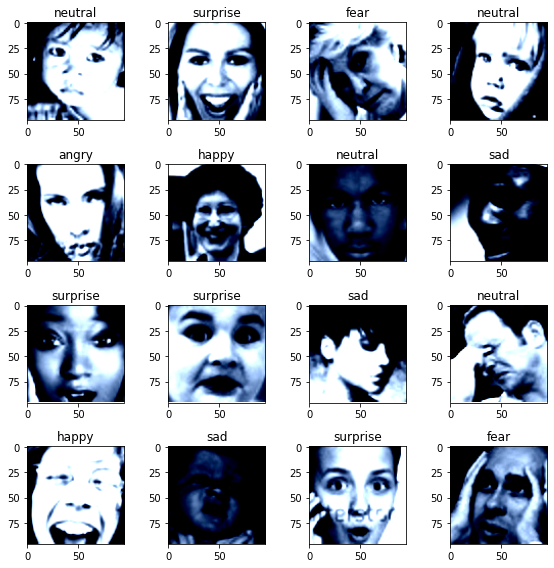

In [7]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i, (image, label) in enumerate(dataset):
        ax[i % 4, i // 4].set_title(train_dataset.classes[label])
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0), cmap='gray')
        if i >= 15:
            break
            
    fig.tight_layout()
    fig.show()            
            
show_batch(test_dataset)          

#### Dataset sizes and classes

In [8]:
print(f'training dataset size: {len(train_dataset)}')
print(f'validaiton dataset size: {len(valid_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

print(f'classes: {train_dataset.classes}')
print(f'class indexes: {train_dataset.class_to_idx}')

training dataset size: 28709
validaiton dataset size: 3589
test dataset size: 3589
classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class indexes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


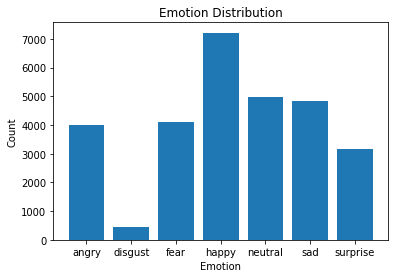

In [9]:
emotion_counts = dict(Counter(train_dataset.targets))

emotion_names = [train_dataset.classes[i] for i in list(emotion_counts.keys())]
emotion_values = list(emotion_counts.values())
plt.bar(range(len(emotion_counts)), emotion_values, tick_label=emotion_names)
plt.title("Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('plots/faces/emotion_distribution.png')
plt.show()

#### Create dataloaders for train, validation and test datasets

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)

## Create CNN model for facial emotion recognition and classification

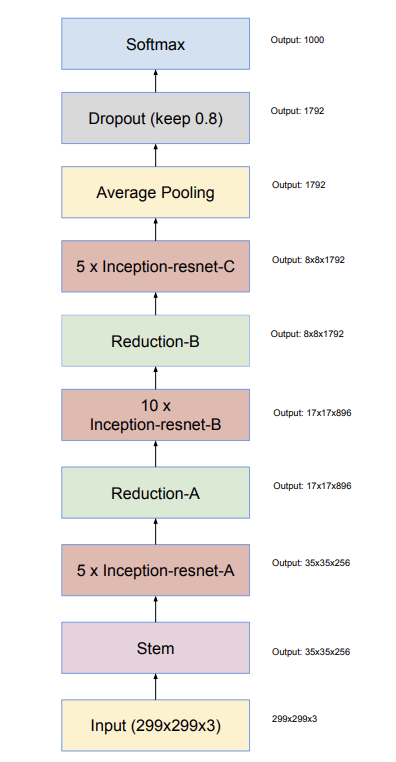

In [11]:
class VggFaceNetwork(nn.Module):
    def __init__(self):
        super(VggFaceNetwork, self).__init__()        
        self.vggface = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=7, dropout_prob=0.1).eval()
        print(self.vggface)

    def forward(self, input):
        output = self.vggface(input)
        return output
    
vgg_face_network = VggFaceNetwork().to(device)
print(summary(vgg_face_network, input_size=(3, image_size, image_size)))    

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 47, 47]             864
       BatchNorm2d-2           [-1, 32, 47, 47]              64
              ReLU-3           [-1, 32, 47, 47]               0
       BasicConv2d-4           [-1, 32, 47, 47]               0
            Conv2d-5           [-1, 32, 45, 45]           9,216
       BatchNorm2d-6           [-1, 32, 45, 45]              64
              ReLU-7           [-1, 32, 45, 45]               0
       BasicConv2d-8           [-1, 32, 45, 45]               0
            Conv2d-9           [-1, 64, 45, 45]          18,432
      BatchNorm2d-10           [-1, 64, 45, 45]             128
             ReLU-11           [-1, 64, 45, 45]               0
      BasicConv2d-12           [-1, 64, 45, 45]               0
        MaxPool2d-13           [-1, 64, 22, 22]               0
           Conv2d-14           [-1, 80,

## Train the CNN for facial emotion classification on the FER 2013 dataset
#### Create training callbacks for saving last epoch, best epoch, reducing learning rate, early stopping and logging the results

In [12]:
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'fer_faces_vgg')
os.makedirs(save_path, exist_ok=True)

plots_dir = 'plots/vgg'
os.makedirs(plots_dir, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    #EarlyStopping(patience=15, verbose=True),
    ReduceLROnPlateau(monitor='val_loss', verbose=True),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

#### Create training optimizer, loss function and Poutyne model. Train the CNN network and evaluate validation and test datsets

In [13]:
trainable_parameters = (parameter for name, parameter in vgg_face_network.named_parameters() if parameter.requires_grad)
optimizer = optim.Adam(trainable_parameters, lr=learning_rate, weight_decay=weight_decay)

loss_function = nn.CrossEntropyLoss()

model = Model(
    vgg_face_network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks    
)

test_loss, (test_acc, test_f1), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

Epoch:  1/50 Train steps: 898 Val steps: 29 2m46.07s loss: 1.143468 acc: 58.002717 fscore_macro: 0.503982 val_loss: 1.005767 val_acc: 63.220953 val_fscore_macro: 0.556521
Epoch 1: val_acc improved from -inf to 63.22095, saving file to saves\fer_faces_vgg\best_epoch_1.ckpt
Epoch:  2/50 Train steps: 898 Val steps: 29 2m37.24s loss: 0.875283 acc: 68.093629 fscore_macro: 0.638144 val_loss: 0.960544 val_acc: 64.474784 val_fscore_macro: 0.597850
Epoch 2: val_acc improved from 63.22095 to 64.47478, saving file to saves\fer_faces_vgg\best_epoch_2.ckpt
Epoch:  3/50 Train steps: 898 Val steps: 29 2m38.41s loss: 0.677059 acc: 75.220314 fscore_macro: 0.727972 val_loss: 1.000560 val_acc: 65.700752 val_fscore_macro: 0.631521
Epoch 3: val_acc improved from 64.47478 to 65.70075, saving file to saves\fer_faces_vgg\best_epoch_3.ckpt
Epoch:  4/50 Train steps: 898 Val steps: 29 2m40.78s loss: 0.476279 acc: 82.845101 fscore_macro: 0.816286 val_loss: 1.078513 val_acc: 66.508777 val_fscore_macro: 0.642922
Ep

Epoch: 28/50 Train steps: 898 Val steps: 29 2m32.68s loss: 0.007753 acc: 99.787523 fscore_macro: 0.997579 val_loss: 1.426007 val_acc: 67.372527 val_fscore_macro: 0.662148
Epoch: 29/50 Train steps: 898 Val steps: 29 2m36.13s loss: 0.007901 acc: 99.791006 fscore_macro: 0.997635 val_loss: 1.415040 val_acc: 66.898858 val_fscore_macro: 0.660861
Epoch: 30/50 Train steps: 898 Val steps: 29 2m34.13s loss: 0.007341 acc: 99.815389 fscore_macro: 0.997877 val_loss: 1.419222 val_acc: 67.400390 val_fscore_macro: 0.663391
Epoch: 31/50 Train steps: 898 Val steps: 29 2m32.36s loss: 0.007342 acc: 99.801456 fscore_macro: 0.997747 val_loss: 1.407998 val_acc: 67.511842 val_fscore_macro: 0.659857
Epoch 31: val_acc improved from 67.42825 to 67.51184, saving file to saves\fer_faces_vgg\best_epoch_31.ckpt
Epoch: 32/50 Train steps: 898 Val steps: 29 2m33.38s loss: 0.007450 acc: 99.794490 fscore_macro: 0.997679 val_loss: 1.430837 val_acc: 67.066035 val_fscore_macro: 0.653788
Epoch: 33/50 Train steps: 898 Val ste

## Print results, accuracy and confusion matrix

In [14]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch        time            lr      loss        acc  fscore_macro  \
0       1  166.066348  1.000000e-04  1.143468  58.002717      0.503982   
1       2  157.244008  1.000000e-04  0.875283  68.093629      0.638144   
2       3  158.413721  1.000000e-04  0.677059  75.220314      0.727972   
3       4  160.784927  1.000000e-04  0.476279  82.845101      0.816286   
4       5  158.741308  1.000000e-04  0.319040  89.076596      0.882616   
5       6  165.101219  1.000000e-04  0.219355  92.472744      0.922020   
6       7  155.941542  1.000000e-04  0.193541  93.664008      0.932421   
7       8  154.925038  1.000000e-04  0.156118  94.931903      0.945973   
8       9  153.881725  1.000000e-04  0.138492  95.419555      0.951827   
9      10  154.473776  1.000000e-04  0.137613  95.454387      0.952222   
10     11  154.301911  1.000000e-04  0.131244  95.771361      0.954354   
11     12  155.868583  1.000000e-04  0.102245  96.847678      0.964899   
12     13  153.765622  1.000000e-05  0

#### Plot loss, accuracy and confusion matrix

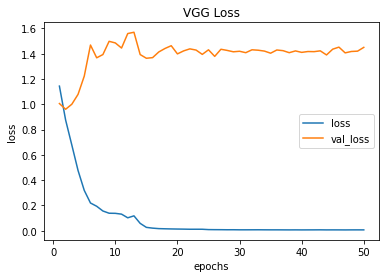

In [15]:
metrics = ['loss', 'val_loss']
plt.title('VGG Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/vgg/emotion_loss.png')
plt.show()

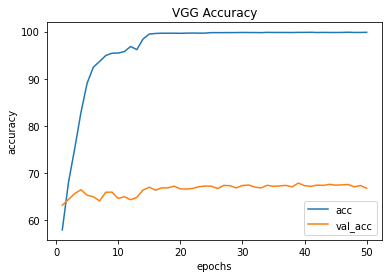

In [16]:
metrics = ['acc', 'val_acc']
plt.title('VGG Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/vgg/emotion_accuracy.png')
plt.show()

Text(87.0, 0.5, 'Prediction')

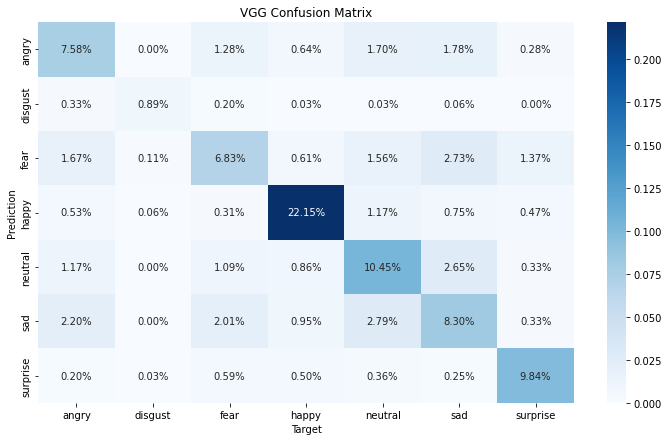

In [17]:
cf_matrix = confusion_matrix(y_true, np.argmax(y_predict, axis=1))
class_names = train_dataset.classes

plt.figure(figsize = (12,7))
plt.title('VGG Confusion Matrix')
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.savefig('plots/vgg/emotion_confusion_matrix.png')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()